In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import zipfile
import shutil

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Any results you write to the current directory are saved as output.

In [81]:
BASE_PATH = '../../data/'
print(os.listdir(BASE_PATH))

['external', 'interim', 'processed', 'raw']


In [40]:
# Read the datasets for the model construction
train = pd.read_csv(os.path.join(BASE_PATH,'train.csv'))
test = pd.read_csv(os.path.join(BASE_PATH,'test.csv'))
submit = pd.read_csv(os.path.join(BASE_PATH,'submit.csv'))

In [41]:
# Display the size of the train and test datasets.
print('The training dataset shape is : ',train.shape)
print('The testing dataset shape is  : ',test.shape)

The training dataset shape is :  (3662, 2)
The testing dataset shape is  :  (1928, 1)


In [42]:
# Display some basic information from the dataset.
print('Train dataset information:', '\n')
train.info()

Train dataset information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [43]:
# Display the first 5 rows from the selected dataset.
print('Train dataset rows example:', '\n')
train.head()

Train dataset rows example: 



,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [44]:
# Display the first 5 rows from the selected dataset.
print('Train dataset rows example:', '\n')
test.head()

Train dataset rows example: 



,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


Image Id:: a06a63d866b2 // Diagnosis :: 0


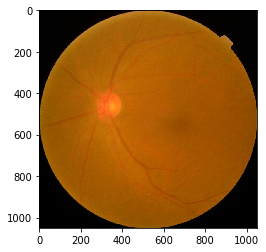

In [55]:
# Display one of the training set images. '002c21358ce6'.
BASE_PATH_TRAINING = os.path.join(BASE_PATH, 'train_images/')
id_code = list(train['id_code'].sample(1))
id_code = str(id_code[0])
img_path = BASE_PATH_TRAINING + id_code + ".png"

diagnosis = int(train[train.id_code == id_code].diagnosis)
print('Image Id:: {} // Diagnosis :: {}'.format(id_code, diagnosis))
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

In [56]:
# Looking to the file structure for train and test folders.
train_dir = os.path.join(BASE_PATH, 'train_images')
train_dir_file_names = os.listdir(train_dir)
test_dir = os.path.join(BASE_PATH, 'test_images')
test_dir_file_names = os.listdir(test_dir)

print('Print image names: ', train_dir_file_names[:8])
print('Total train images:', len(os.listdir(train_dir)),'\n')
print('Print image names: ', test_dir_file_names[:8])
print('Total test images:', len(os.listdir(test_dir)))

Print image names:  ['000c1434d8d7.png', '001639a390f0.png', '0024cdab0c1e.png', '002c21358ce6.png', '005b95c28852.png', '0083ee8054ee.png', '0097f532ac9f.png', '00a8624548a9.png']
Total train images: 3662 

Print image names:  ['0005cfc8afb6.png', '003f0afdcd15.png', '006efc72b638.png', '00836aaacf06.png', '009245722fa4.png', '009c019a7309.png', '010d915e229a.png', '0111b949947e.png']
Total test images: 1928


In [57]:
# Naming the dataset base on clinician severity
# 0 - no_dr
# 1 - mild
# 2 - moderate
# 3 - severe
# 4 - proliferative_dr

def add_severity(df):
    '''Add a new columns to the dataset with the clinical severity '''
    conditions = [(df['diagnosis'] == 0),(df['diagnosis'] == 1),(df['diagnosis'] == 2),(df['diagnosis'] == 3),(df['diagnosis'] == 4)]
    choices = ['no_dr', 'mild', 'moderate', 'severe', 'proliferative_dr']
    df['severity'] = np.select(conditions, choices, default = 'other')
    return df

train = add_severity(train)
train.head()

,id_code,diagnosis,severity
0,000c1434d8d7,2,moderate
1,001639a390f0,4,proliferative_dr
2,0024cdab0c1e,1,mild
3,002c21358ce6,0,no_dr
4,005b95c28852,0,no_dr


In [58]:
for id_code, _, severity in train[:10].values:
    print(id_code, severity)

000c1434d8d7 moderate
001639a390f0 proliferative_dr
0024cdab0c1e mild
002c21358ce6 no_dr
005b95c28852 no_dr
0083ee8054ee proliferative_dr
0097f532ac9f no_dr
00a8624548a9 moderate
00b74780d31d moderate
00cb6555d108 mild


In [66]:
# Model Hyperparameters
BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
EPOCHS = 10
VERBOSE = 1
HEIGHT = 128
WIDTH = 128
NUM_CLASSES = 5
LEARNING_RATE = 0.0001

In [63]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '../../models/pre-trained_models/inception-v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = None)
pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
# Make the last n layers in the pre-trained model trainable
trainable_layers = -1
for idx in range(trainable_layers, 0):
    pre_trained_model.layers[idx] = True

In [64]:
# Extract the model  last layer for training
last_layer = pre_trained_model
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 2, 2, 2048)


In [67]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)           

model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr = LEARNING_RATE), loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 63, 63, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 63, 63, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 63, 63, 32)   0           batch_normalization_376[0][0]    
______________________________________________________________________________________________

In [73]:
TRAIN_DF = train.copy()
TRAIN_DF['filename'] = TRAIN_DF['id_code'] + '.png'
TRAIN_DF['diagnosis'] = TRAIN_DF['diagnosis'].astype('str')

TEST_DF = test.copy()
TEST_DF['filename'] = TEST_DF['id_code'] + '.png'

In [92]:
TRAINING_DIR = "../../data/raw/train_images/"
TESTING_DIR = "../../data/raw/test_images/"

training_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, validation_split = 0.2)

train_generator = training_datagen.flow_from_dataframe(dataframe = TRAIN_DF, 
                                                       directory  = TRAINING_DIR, 
                                                       x_col = 'filename', 
                                                       y_col = 'severity',
                                                       classes = ['no_dr','mild','moderate','severe','proliferative_dr'],
                                                       batch_size = BATCH_SIZE,
                                                       target_size = (HEIGHT,WIDTH), 
                                                       class_mode = 'categorical',  
                                                       subset = 'training'
                                                      )


valid_generator = training_datagen.flow_from_dataframe(dataframe = TRAIN_DF, 
                                                       directory  = TRAINING_DIR, 
                                                       x_col = 'filename', 
                                                       y_col = 'severity',
                                                       classes = ['no_dr','mild','moderate','severe','proliferative_dr'],
                                                       batch_size = BATCH_SIZE,
                                                       target_size = (HEIGHT,WIDTH), 
                                                       class_mode = 'categorical',  
                                                       subset = 'validation'
                                                      )


testing_datagen = ImageDataGenerator(rescale = 1./255)
testing_generator = testing_datagen.flow_from_dataframe(dataframe = TEST_DF, directory  = TESTING_DIR, target_size = (HEIGHT, WIDTH), batch_size = TEST_BATCH_SIZE, shuffle = False, class_mode = None)

print('\n', train_generator.class_indices)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.

 {'mild': 0, 'moderate': 1, 'no_dr': 2, 'proliferative_dr': 3, 'severe': 4}


In [93]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [ ]:
# Training the CNN Model
model.fit_generator(train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data = valid_generator, validation_steps = STEP_SIZE_VALID, epochs = EPOCHS, verbose = VERBOSE)

Epoch 1/10
69/91 [=====================>........] - ETA: 48s - loss: 1.5735 - acc: 0.5474